# Stochastic analysis of time series

algorithm by "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## 1. Drift and Diffusion coefficients

They are defined in \[1\](4) as

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

In case of HO they write:
$$
D^{(1)}_{x} = \lim_{\tau \to 0} \frac{1}{\tau} < x(t + \tau) - x(t) >
\\
D^{(1)}_{v} = \lim_{\tau \to 0} \frac{1}{\tau} < v(t + \tau) - v(t) >
$$

As there are no limes-funcitons implemented, we will use the value of $D^{(i)}$ where $\tau$ equals the smallest possible value. Thus $\tau$ needs to be a integer value greater than 0, $\tau$ will be assumed as 1: $\lim_{\tau \to 0} \tau := 1$

In [2]:
def D_1(series, dt, bins=250, tau=1, transform=None):
    ''' Retrieving n-dimensional Drift-Coefficient
    
    Parameters:
        - (array) series: array of n arrays which represent time series. n-dimensinal.
        - (float) dt: (time) difference between the values of series.
        - (int) bins: Number of bins. Defines the accuracy.
        - (int) tau: Number of timesteps to derivate further.
        - (lambda) transform: transform function to project series value to mesh.
            default: transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
        
    Returns:
        (array) Array of n-dim arrays, where the arrays represent the mean change of the i-th variable.
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate changes of the series and write to mesh
        for j in range(dimension):
            a_grid[j][c] += series[j][i + tau] - series[j][i]
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

In [3]:
def D_2(series, dt, bins=250, tau=1, transform=None):
    '''Retrieving n-dimensional Diffusion-Coefficient
    
    [tba. - can be copied from D_1]
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    a_grid = [a_grid[0] for _ in range(dimension * dimension)]
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate and multiply changes of the series and write to mesh
        for k in range(dimension):
            for j in range(dimension):
                d_c = k * dimension + j
                a_grid[d_c][c] += (series[j][i + tau] - series[j][i]) * (series[k][i + tau] - series[k][i])
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

In [4]:
# default and often used variables and functions. To be exported in class later on.

# 1. standard transform function
transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1

# 2. standard axis
normaxis = lambda bins, dimension: np.meshgrid(*[np.arange(0, bins) for _ in range(dimension)])

# 3. visualize D_1 and D_2 results as one plot
def visualize_results_2d(drift, diffusion):
    fig = plt.figure()
    
    dimension = len(drift)
    for i in range(dimension):
        plt.subplot(1, dimension, i + 1)
        plt.imshow(drift[i], cmap='hot')
        plt.title('$D^{(1)}_{x_' + str(i) + '}$')
        plt.xlabel('$x_0$')
        plt.ylabel('$x_1$')
    plt.show()

    # above D1
    # --------
    # below D2
    fig = plt.figure()
    
    a = lambda x, dim: int((((x - (x % dim)) / dim)) * dim)
    b = lambda x, dim: int(x - a(x, dim))
    
    dimension = len(diffusion)
    sqrtdim = int(np.sqrt(dimension))
    for i in range(dimension):
        plt.subplot(1, dimension, i + 1)
        plt.imshow(diffusion[i], cmap='hot')
        plt.title('$D^{(2)}_{x_{' + str(a(i, sqrtdim)) + '}x_{' + str(b(i, sqrtdim)) + '}}$')
        plt.xlabel('$x_0$')
        plt.ylabel('$x_1$')
    plt.show()

## 2. Applying on time series

We will use different time series. For one example we will use the harmonic oscillator (HO). The HO is defined as follows:

$$
\dot{x} = v\\
\dot{v} = -f'(x) + \Gamma(t) - \gamma v
$$

Furthermore we will use a Langevin-Equation to create somewhat a telegram-signal:

$$
\dot{X}(t) = \varepsilon X(t) - X^{3}(t) - \gamma \Gamma (t)\\
\varepsilon = 0.1 \text{ and } \gamma = 0.05
$$

Where Gamma represents a gaussian white noise. The time series can be derived by integration. This will be done in the following.

### 2.1 Harmonic Oscillator

#### 2.1.1 Creating time series

In [107]:
dt = 0.001
T = 800 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0
epsilon = 0.01

x = []
v = []
x = np.zeros(n)
v = np.zeros(n)
x[0] = 1
v[0] = 0

f = lambda x: x

for i in range(n - 1):
    x[i + 1] = x[i] + dt * v[i]
    v[i + 1] = v[i] - dt * (f(x[i + 1]) + gamma * v[i]) + sqrtdt * np.random.randn() * epsilon

<IPython.core.display.Javascript object>


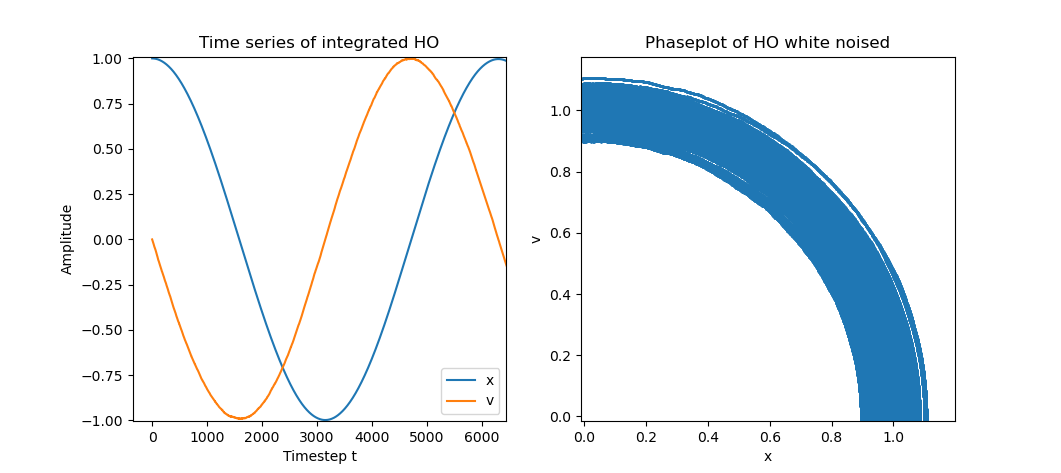

In [6]:
%matplotlib notebook

plt.subplot(121)
plt.plot(x, label='x')
plt.plot(v, label='v')
plt.title('Time series of integrated HO')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.scatter(x, v, s=1, label='phaseplot')
plt.title('Phaseplot of HO white noised')
plt.xlabel('x')
plt.ylabel('v')

plt.show()

#### 2.1.2 Retrieving Drift and Diffusion coefficients

In [108]:
bins = 250
dimension = 2
xv, yv = normaxis(bins, dimension)

In [109]:
drift = D_1([x, v], dt, bins)

In [110]:
diffusion = D_2([x, v], dt, bins)

<IPython.core.display.Javascript object>


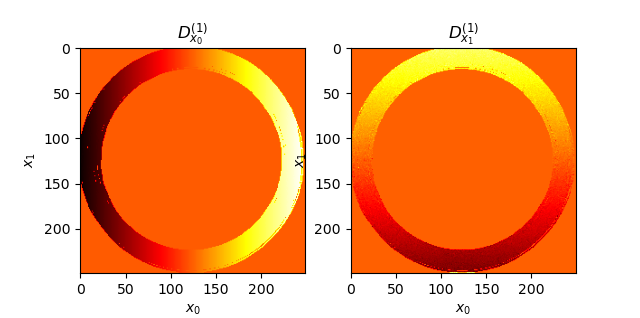

<IPython.core.display.Javascript object>


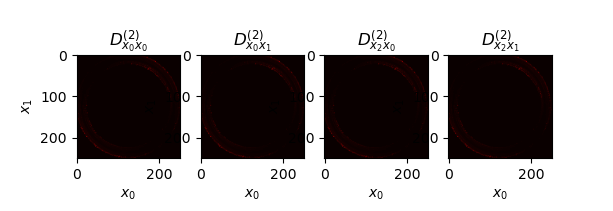

In [10]:
%matplotlib notebook

visualize_results_2d(drift, diffusion)

#### 2.1.4 Solving Fokker-Planck-Equation

In [ ]:
# tba. analytic solution in FPE.ipynb

#### 2.1.3 Reconstructing time series

In [ ]:
dt = 0.01
T = 200 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

epsilon = 0.01

x_ = []
v_ = []
x_ = np.zeros(n)
v_ = np.zeros(n)
x_[0] = 1
v_[0] = 0

dx = np.max(x) - np.min(x)
dv = np.max(v) - np.min(v)

for i in range(n - 1):
    x_[i + 1] = x_[i]
    v_[i + 1] = v_[i]
    # 1. deterministic dynamics
    x_[i + 1] += drift[0][transform(x_[i], dx, bins)][transform(v_[i], dv, bins)] * dt
    v_[i + 1] += drift[1][transform(x_[i], dx, bins)][transform(v_[i], dv, bins)] * dt
    # 2. stochastic dynamics
    # ToDo: Implement noise amplitudes g_ij() [?] and random gamma. [1](12)
    x_[i + 1] += sqrtdt * np.random.randn() * epsilon
    v_[i + 1] += sqrtdt * np.random.randn() * epsilon

<IPython.core.display.Javascript object>


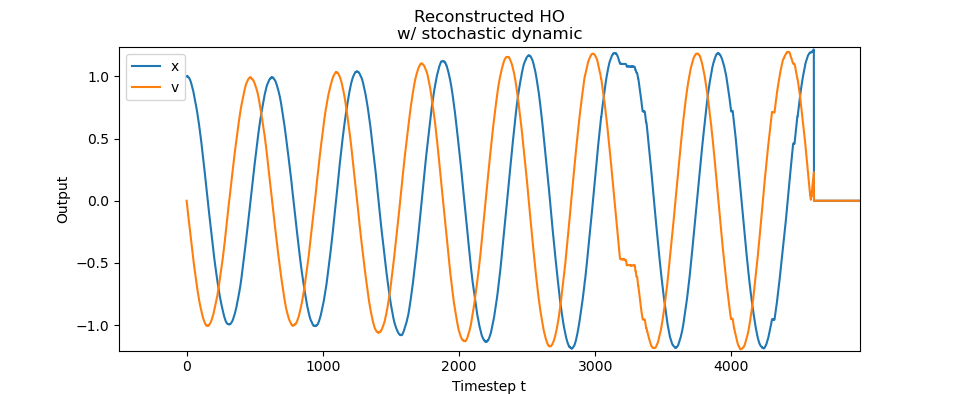

In [445]:
%matplotlib notebook
plt.plot(x_, label='x')
plt.plot(v_, label='v')

plt.title('Reconstructed HO\nw/ stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')
plt.legend()

plt.show()

### 2.2 Van-der-Pol oscillator

#### 2.2.1 Creating time series

In [412]:
dt = 0.01
T = 200 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

def f(t, x):
    '''Van-der-Pol oscillator
    '''
    epsilon = 2
    mu = 3
    kappa = 10
    y = [0, 0]
    # 1. deterministic
    y[0] = x[1]
    y[1] = epsilon * (1 - x[0] ** 2) * x[1] - mu ** 2 * x[0]
    # 2. stochastic
    y[0] += sqrtdt * np.random.randn() * kappa
    y[1] += sqrtdt * np.random.randn() * kappa
    return y

sol = solve_ivp(f, [0, T], [0, 1], dense_output=True)

t = np.linspace(0, T, n)
x, v = sol.sol(t)

<IPython.core.display.Javascript object>


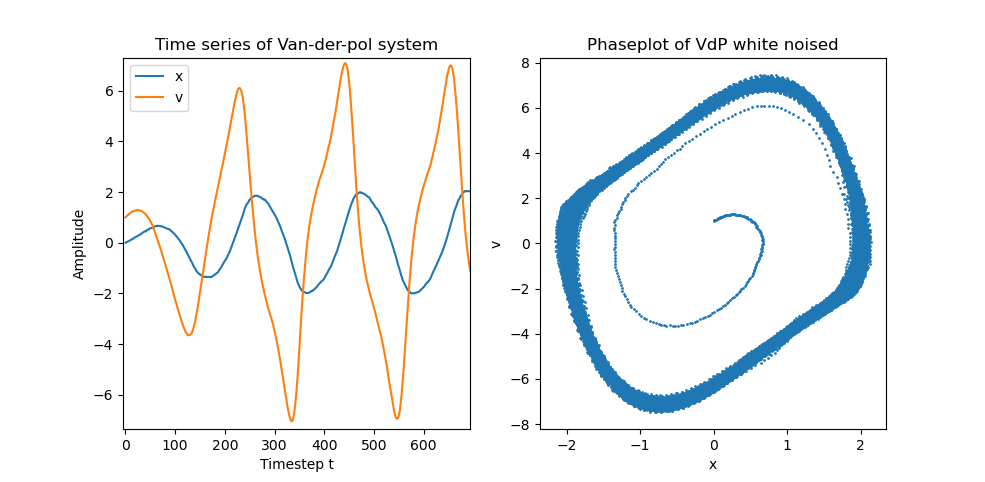

In [340]:
%matplotlib notebook
plt.subplot(121)
plt.plot(x, label='x')
plt.plot(v, label='v')
plt.title('Time series of Van-der-pol system')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.scatter(x, v, s=1, label='phaseplot')
plt.title('Phaseplot of VdP white noised')
plt.xlabel('x')
plt.ylabel('v')

plt.show()

#### 2.2.2 Retrieving Drift and Diffusion coefficients

In [413]:
bins = 100
dimension = 2
xv, yv = normaxis(bins, dimension)

In [414]:
drift = D_1([x, v], dt, bins)

In [415]:
diffusion = D_2([x, v], dt, bins)

<IPython.core.display.Javascript object>


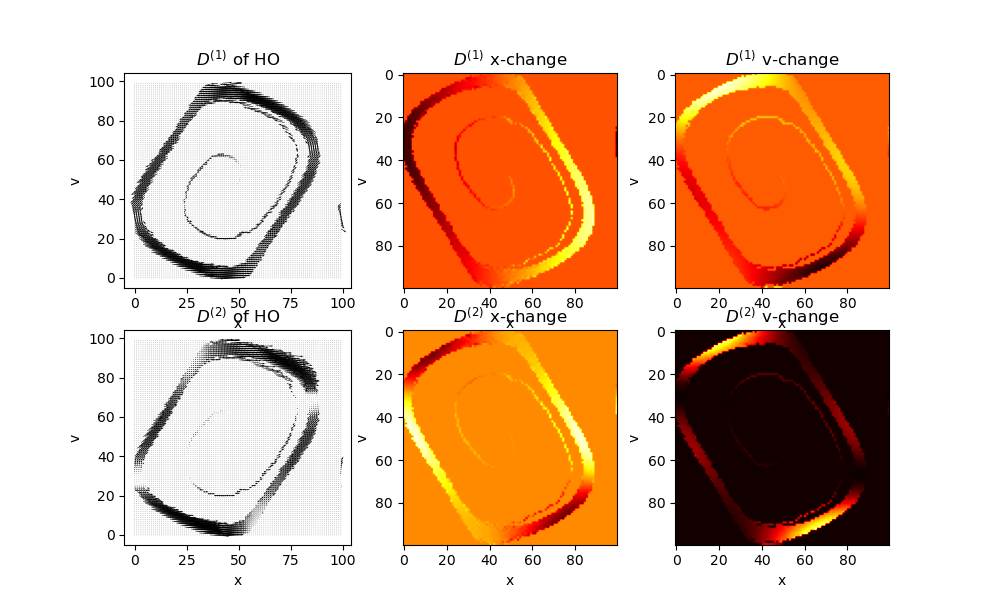

In [416]:
%matplotlib notebook

visualize_results_2d(drift, diffusion)

<IPython.core.display.Javascript object>


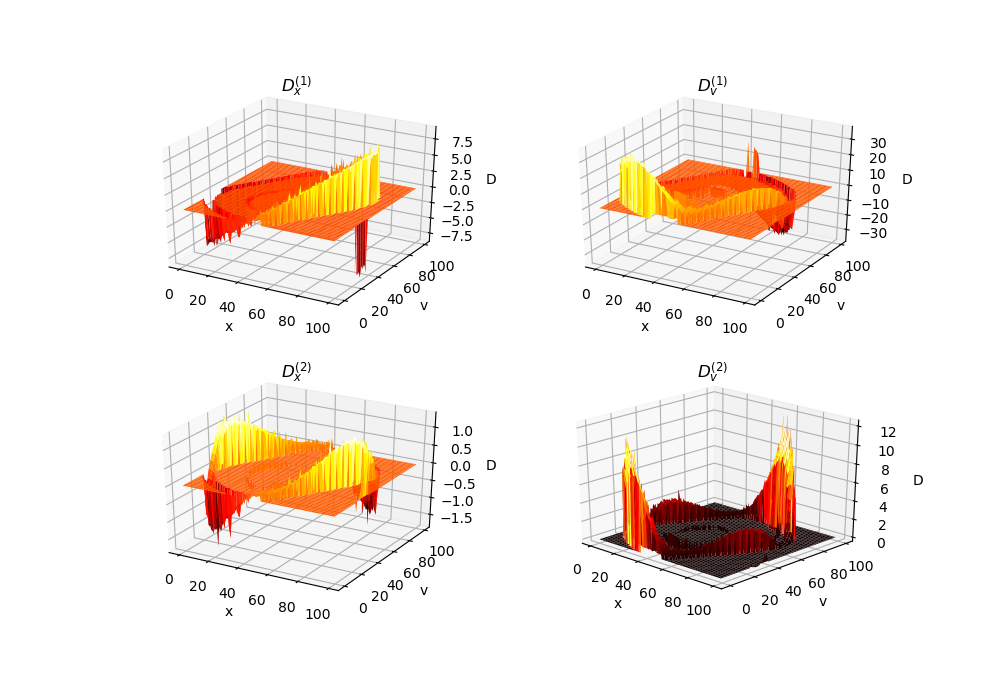

In [418]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(xv, yv, drift[0], cmap='hot')
ax.set_title('$D^{(1)}_x$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('D')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(xv, yv, drift[1], cmap='hot')
ax.set_title('$D^{(1)}_v$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('D')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(xv, yv, diffusion[0], cmap='hot')
ax.set_title('$D^{(2)}_x$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('D')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(xv, yv, diffusion[1], cmap='hot')
ax.set_title('$D^{(2)}_v$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('D')

plt.show()

#### 2.2.3 Reconstructing time series

In [366]:
dt = 0.01
T = 200 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

x_ = []
v_ = []
x_ = np.zeros(n)
v_ = np.zeros(n)
x_[0] = 0
v_[0] = 1

epsilon = 0.01

dx = np.max(x) - np.min(x)
dv = np.max(v) - np.min(v)

for i in range(n - 1):
    x_[i + 1] = x_[i]
    v_[i + 1] = v_[i]
    # 1. deterministic dynamics
    x_[i + 1] += drift[0][transform(x_[i], dx, bins)][transform(v_[i], dv, bins)] * dt
    v_[i + 1] += drift[1][transform(x_[i], dx, bins)][transform(v_[i], dv, bins)] * dt
    # 2. stochastic dynamics
    # ToDo: Implement noise amplitudes g_ij() [?] and random gamma. [1](12)
    x_[i + 1] += sqrtdt * np.random.randn() * epsilon
    v_[i + 1] += sqrtdt * np.random.randn() * epsilon

<IPython.core.display.Javascript object>


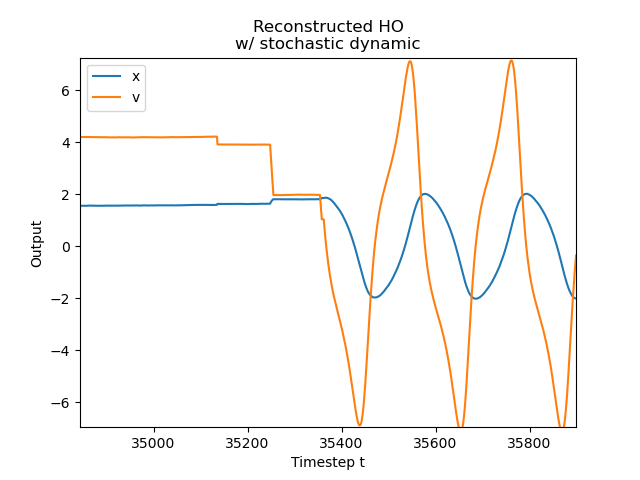

In [367]:
%matplotlib notebook
plt.plot(x_, label='x')
plt.plot(v_, label='v')

plt.title('Reconstructed HO\nw/ stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')
plt.legend()

plt.show()

### 2.3 Langevin telegram signal

#### 2.3.1 Creating time series

In [423]:
dt = 0.01
T = 10000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

langevin =[]
langevin = np.zeros(n)

for i in range(n - 1):
    langevin[i + 1] = langevin[i] + dt * (epsilon * langevin[i] - langevin[i] ** 3) +\
                      sqrtdt * gamma * np.random.randn()

<IPython.core.display.Javascript object>


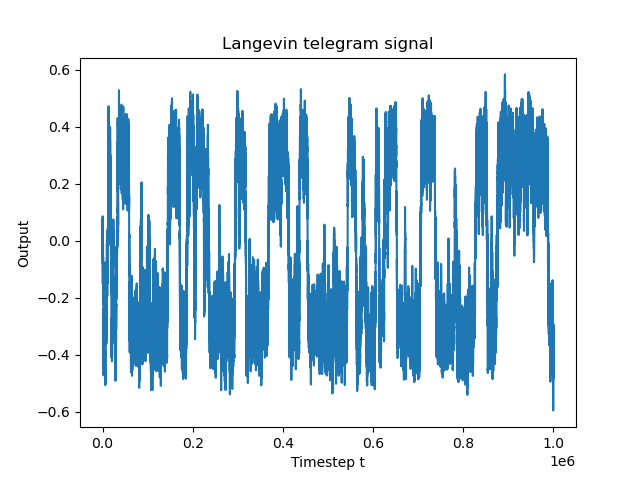

In [424]:
%matplotlib notebook
plt.plot(langevin, label='Langevin')

plt.title('Langevin telegram signal')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

#### 2.3.2 Retrieving Drift and Diffusion coefficients

In [425]:
bins = 250

In [426]:
drift = D_1([langevin], dt, bins)

In [427]:
diffusion = D_2([langevin], dt, bins)

<IPython.core.display.Javascript object>


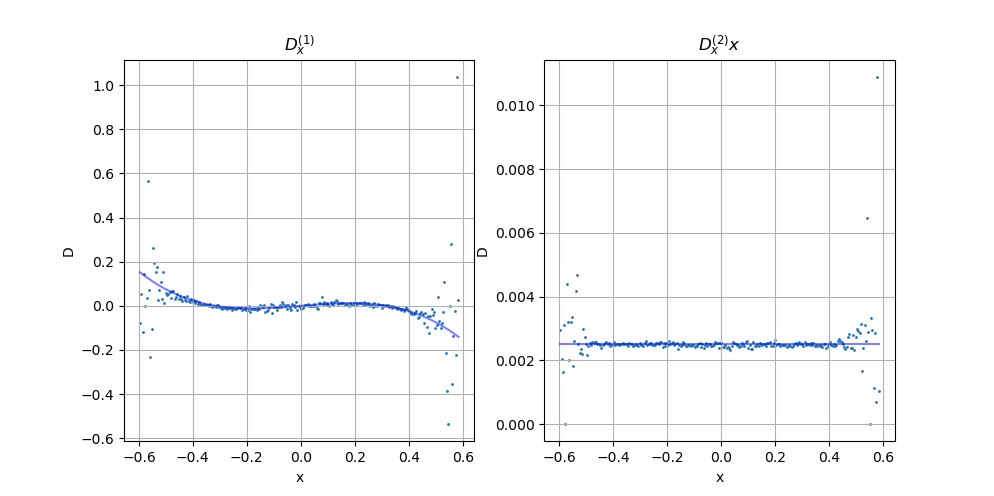

In [428]:
%matplotlib notebook

arl = np.linspace(np.min(langevin), np.max(langevin), bins)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(arl, drift[0], label='$D^{(1)}_x$', s=1)
ax.plot(arl, [0.1 * el - el ** 3 for el in arl], alpha=0.5, c='b', label='analytic')
ax.set_title('$D^{(1)}_x$')
ax.set_xlabel('x')
ax.set_ylabel('D')
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(arl, diffusion[0], label='$D^{(2)}_x$', s=1)
ax.plot(arl, [0.0025 for _ in arl], alpha=0.5, c='b', label='analytic')
ax.set_title('$D^{(2)}_{xx}$')
ax.set_xlabel('x')
ax.set_ylabel('D')
ax.grid()

plt.show()

#### 2.3.3 Reconstructing time series

In [431]:
dt = 0.01
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

x = np.zeros(n)

dx = np.max(langevin) - np.min(langevin)

for i in range(n - 1):  
    x[i + 1] = x[i]
    # 1. Deterministic dynamics
    x[i + 1] += drift[0][transform(x[i], dx, bins)] * dt
    # 2. Stochastic dynamics
    x_[i + 1] += sqrtdt * np.random.randn() * epsilon

<IPython.core.display.Javascript object>


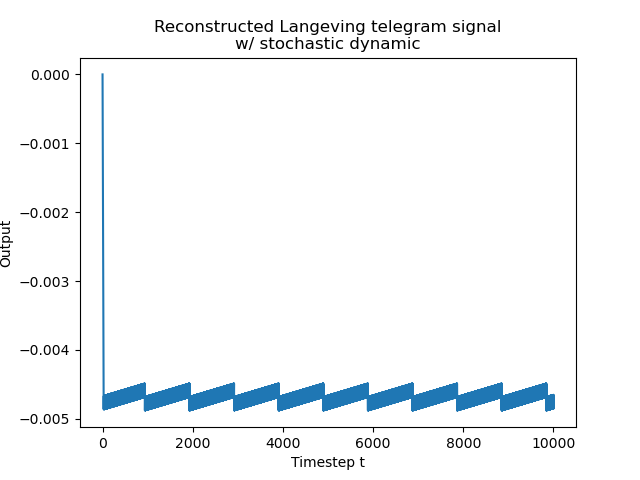

In [432]:
%matplotlib notebook
plt.plot(x, label='Langevin')

plt.title('Reconstructed Langeving telegram signal\nw/ stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

### 2.4 Lorenz attractor

#### 2.4.1 Creating time series

In [1610]:
dt = 0.01
T = 1000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

s = 10
r = 28
b = (8 / 3)

g = [[4, 5, 3], 
     [5, 5, 6],
     [3, 6, 10]]
#g = [[0, 0, 0],
#     [0, 0, 0],
#     [0, 0, 0]]

xs = []
ys = []
zs = []
xs = np.zeros(n)
ys = np.zeros(n)
zs = np.zeros(n)
xs[0], ys[0], zs[0] = (0, 1, 1.05)

for i in range(n - 1):
    xs[i + 1] = xs[i] + (s * (ys[i] - xs[i])) * dt +\
        np.sum([g[0][i] * np.random.randn() for i in range(len(g[0]))]) * sqrtdt
    ys[i + 1] = ys[i] + (r * xs[i] - ys[i] - xs[i] * zs[i]) * dt +\
        np.sum([g[1][i] * np.random.randn() for i in range(len(g[1]))]) * sqrtdt
    zs[i + 1] = zs[i] + (xs[i] * ys[i] - b * zs[i]) * dt +\
        np.sum([g[2][i] * np.random.randn() for i in range(len(g[2]))]) * sqrtdt

In [ ]:
%matplotlib notebook
plt.plot(xs, label='x')
plt.plot(ys, label='y')
plt.plot(zs, label='z')

plt.title('Time series of Lorenz attractor')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Phaseplot of Lorenz attractor")

plt.show()

#### 2.4.2 Retrieving Drift and Diffusion coefficients

In [1612]:
bins = 100
dimension = 3
xv, yv, zv = normaxis(bins, dimension)

In [ ]:
drift = D_1([xs, ys, zs], bins)

In [ ]:
diffusion = D_2([xs, ys, zs], bins)

In [ ]:
%matplotlib notebook

# vector field
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.quiver(xv, yv, zv, drift[0], drift[1], drift[2], lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("$D^{(1)}$ of Lorenz attractor")
plt.show()

#### 2.4.3 Reconstructing time series

## Literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996